## 필요한 library import

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Data Preprocessing

In [2]:
# load data
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
# train/test data set 구축
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복된 데이터와 NaN 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words).most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
# word dictionary 생성
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
# 텍스트 길이 확인
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이 = (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# train/validation/test data set 구축 
word_to_index={word:index for index, word in index_to_word.items()}

x_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

## Train & Test

In [8]:
vocab_size = 10000  
word_vector_dim = maxlen 

### 1st try

In [9]:
# model 1 정의
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

In [10]:
# word2vec 사용 
word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/7/ko.bin'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [11]:
# model 1 정의, word2vec 적용
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_shape=(None,),
                                 input_length=maxlen, 
                                 trainable=True))
model1.add(keras.layers.LSTM(8))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1600      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


In [12]:
# model 1 학습
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 3  
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/3
229/229 [==============================] - 7s 17ms/step - loss: 0.6012 - accuracy: 0.6751 - val_loss: 0.3687 - val_accuracy: 0.8393
Epoch 2/3
229/229 [==============================] - 3s 14ms/step - loss: 0.3317 - accuracy: 0.8623 - val_loss: 0.3481 - val_accuracy: 0.8474
Epoch 3/3
229/229 [==============================] - 3s 14ms/step - loss: 0.2982 - accuracy: 0.8766 - val_loss: 0.3474 - val_accuracy: 0.8479


In [13]:
loss, accuracy = model1.evaluate(x_test,  y_test, verbose=2)
print("loss: ", loss)
print("accuracy: ", accuracy)

1537/1537 - 5s - loss: 0.3514 - accuracy: 0.8477
loss:  0.35135552287101746
accuracy:  0.84769207239151


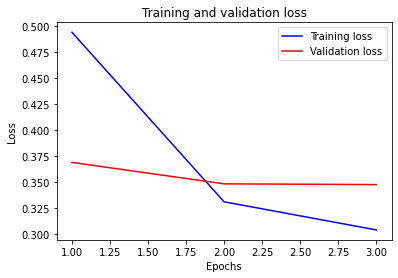

In [14]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

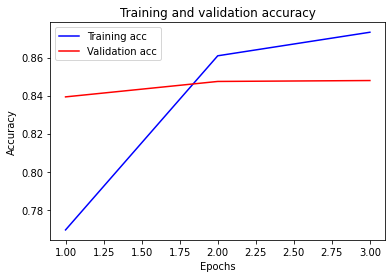

In [15]:
plt.clf() 

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1st try에서 val_loss가 감소할 때는 보통 epochs=3일때까지 였고, 그 이후로는 증가하는 경향을 보였다. 이것은 4번째 epoch부터 overfitting을 뜻하기 때문에 epochs=3로 설정했다.<br/>
accuracy: 0.8477

### 2nd try

In [30]:
# model 2 정의
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid')) 

In [31]:
# word2vec 사용 
word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/7/ko.bin'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [32]:
# model 2 정의
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_shape=(None,),
                                 input_length=maxlen, 
                                 trainable=True))   
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [33]:
# model 2 학습
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])          
epochs = 4  
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/4
229/229 [==============================] - 3s 12ms/step - loss: 0.6933 - accuracy: 0.4989 - val_loss: 0.6926 - val_accuracy: 0.5053
Epoch 2/4
229/229 [==============================] - 2s 11ms/step - loss: 0.5960 - accuracy: 0.6316 - val_loss: 0.3600 - val_accuracy: 0.8426
Epoch 3/4
229/229 [==============================] - 2s 11ms/step - loss: 0.3212 - accuracy: 0.8657 - val_loss: 0.3503 - val_accuracy: 0.8481
Epoch 4/4
229/229 [==============================] - 3s 11ms/step - loss: 0.2854 - accuracy: 0.8824 - val_loss: 0.3465 - val_accuracy: 0.8514


In [34]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=2)
print("loss: ", loss)
print("accuracy: ", accuracy)

1537/1537 - 3s - loss: 0.3494 - accuracy: 0.8510
loss:  0.34937265515327454
accuracy:  0.8509876728057861


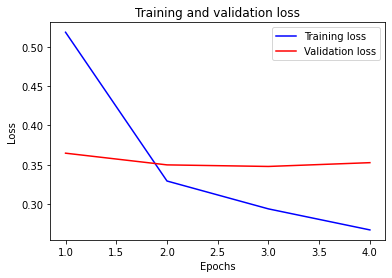

In [21]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

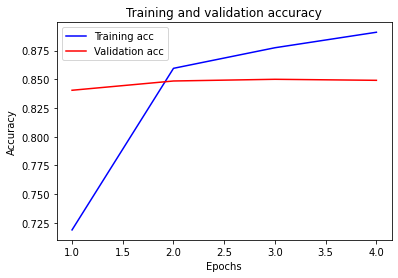

In [22]:
plt.clf()  

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

2nd try에서 val_loss가 감소할 때는 보통 epochs=4 일때까지 였고, 그 이후로는 증가하는 경향을 보였다.<br/>
accuracy: 0.8510

### 3rd try

In [23]:
# model 3 정의
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [24]:
# word2vec 사용 
word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/7/ko.bin'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [25]:
# model 3 정의
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_shape=(None,),
                                 input_length=maxlen, 
                                 trainable=True))   
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 41)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 336       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [26]:
# model 3 학습
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])             
epochs = 6  
history = model3.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/6
229/229 [==============================] - 2s 8ms/step - loss: 0.6968 - accuracy: 0.5003 - val_loss: 0.6934 - val_accuracy: 0.5075
Epoch 2/6
229/229 [==============================] - 2s 8ms/step - loss: 0.6920 - accuracy: 0.5126 - val_loss: 0.6861 - val_accuracy: 0.5306
Epoch 3/6
229/229 [==============================] - 2s 8ms/step - loss: 0.6602 - accuracy: 0.6373 - val_loss: 0.5361 - val_accuracy: 0.7436
Epoch 4/6
229/229 [==============================] - 2s 8ms/step - loss: 0.4895 - accuracy: 0.7734 - val_loss: 0.4269 - val_accuracy: 0.8030
Epoch 5/6
229/229 [==============================] - 2s 8ms/step - loss: 0.3988 - accuracy: 0.8229 - val_loss: 0.3997 - val_accuracy: 0.8208
Epoch 6/6
229/229 [==============================] - 2s 8ms/step - loss: 0.3619 - accuracy: 0.8428 - val_loss: 0.3880 - val_accuracy: 0.8250


In [27]:
loss, accuracy = model3.evaluate(x_test,  y_test, verbose=2)
print("loss: ", loss)
print("accuracy: ", accuracy)

1537/1537 - 2s - loss: 0.3851 - accuracy: 0.8269
loss:  0.3851051330566406
accuracy:  0.8268608450889587


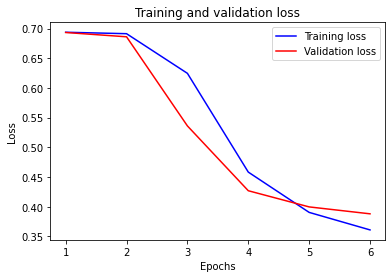

In [28]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

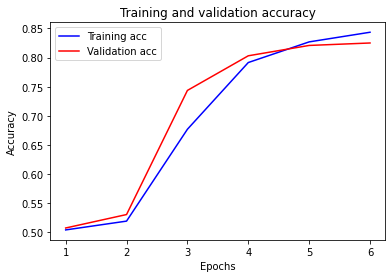

In [29]:
plt.clf()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3rd try에서 val_loss가 감소할 때는 보통 epochs=3일때까지 였고, 그 이후로는 증가하는 경향을 보였다.<br/>
accuracy: 0.8269

## Conclusion

1-D Convolution Neural Network(1-D CNN)를 사용할 때 가장 높은 정확도(85.10%)를 얻을 수 있었기 때문에, 이 모델이 내가 세팅한 환경에서는 최적 모델이라는 것을 알 수 있었다.

## 회고

- 이번 프로젝트에서 어려웠던 점
    - 새로운 모델을 접하게 되면서 그 모델의 특징을 파악하는데 많은 시간이 걸렸다.
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 이번에도 어떤 모델을 왜 쓰고, 어떤 층은 왜 써야 하는지 모호했다.
- 자기 다짐
    - CS231n 수업을 열심히 들으면서 학습 모델을 만드는 원리에 대해 알아가야겠다.